## Data Loading:

In [1]:
#importing the required libraries:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from PIL import Image
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

In [2]:
#loading data:
train_csv_path = "/Users/architmurgudkar/Documents/MDSI/ILAB/final_dataset/data/img_train.csv"
val_csv_path = "/Users/architmurgudkar/Documents/MDSI/ILAB/final_dataset/data/img_val.csv"
test_csv_path = "/Users/architmurgudkar/Documents/MDSI/ILAB/final_dataset/data/img_test.csv"
img_dir = "/Users/architmurgudkar/Documents/MDSI/ILAB/final_dataset/data/skincap/"

#read CSV files:
train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)
test_df = pd.read_csv(test_csv_path)

In [3]:
#printing top 5 rows:
train_df.head()

,skincap_file_path,disease,Vesicle,Papule,Macule,Plaque,Abscess,Pustule,Bulla,Patch,...,Blue,Umbilicated,Poikiloderma,Salmon,Wheal,Acuminate,Burrow,Gray,Pigmented,Cyst
0,2689.png,melanoma,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2936.png,vitiligo,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1539.png,nevus sebaceous of jadassohn,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2095.png,neutrophilic dermatoses,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3229.png,allergic contact dermatitis,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#checking on duplicates:
train_df.duplicated().sum()

0

## Exploring Data:

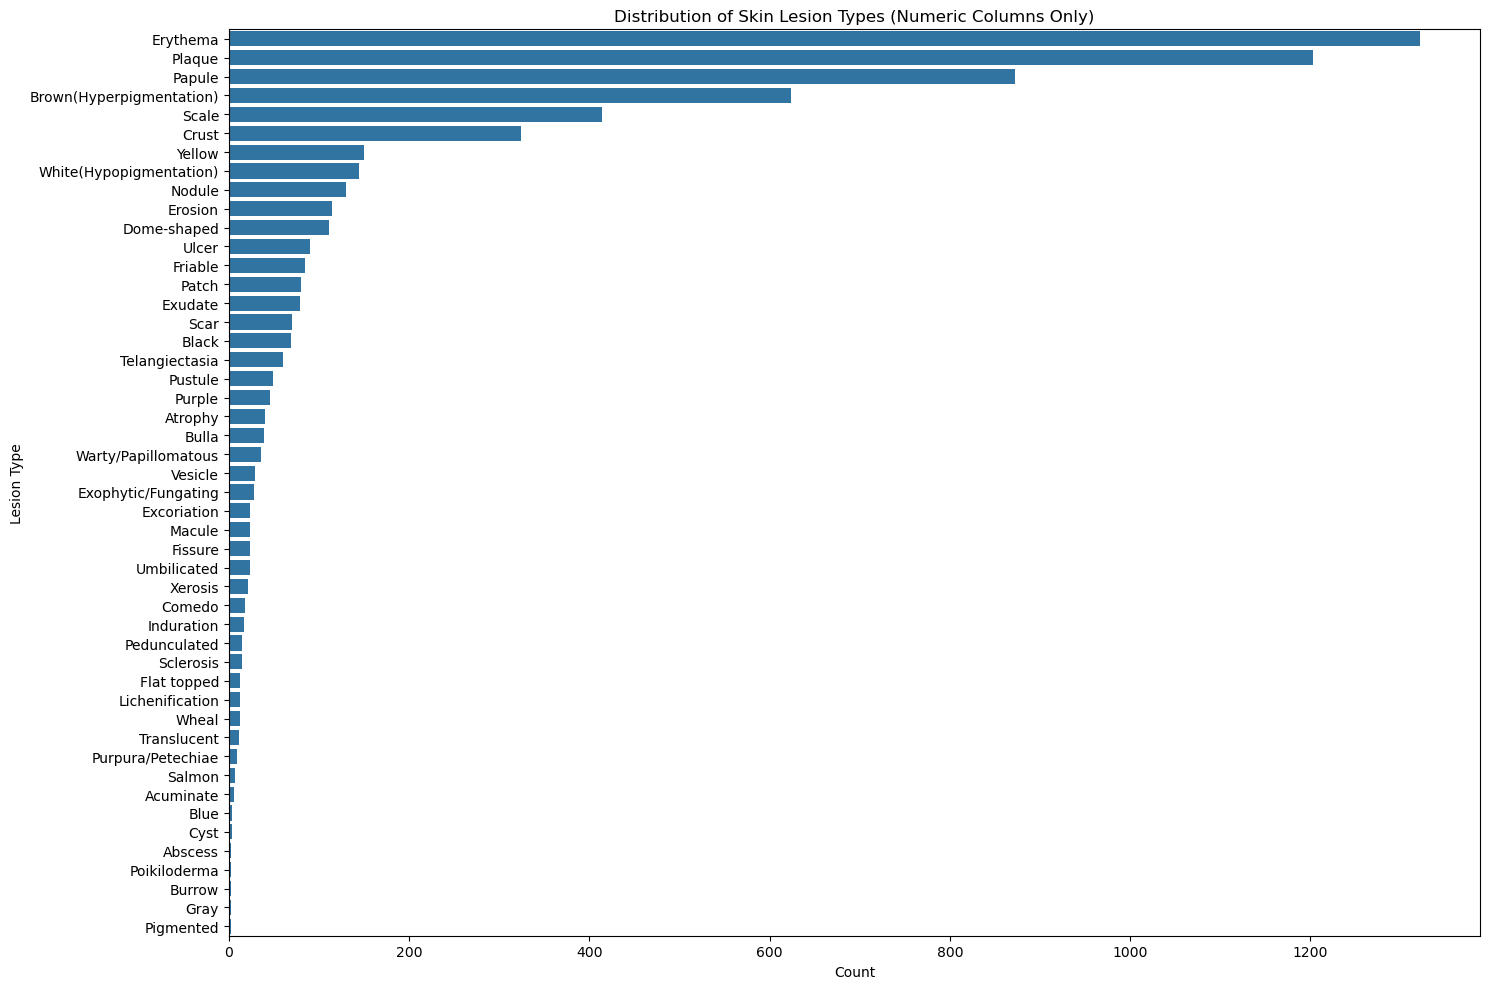

In [5]:
#plotting distribution:
def plot_lesion_distribution(df):
    # Identify numeric columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    
    # Sum only the numeric columns
    lesion_counts = df[numeric_columns].sum().sort_values(ascending=False)
    
    plt.figure(figsize=(15, 10))
    sns.barplot(x=lesion_counts.values, y=lesion_counts.index)
    plt.title('Distribution of Skin Lesion Types (Numeric Columns Only)')
    plt.xlabel('Count')
    plt.ylabel('Lesion Type')
    plt.tight_layout()
    plt.show()


plot_lesion_distribution(train_df)

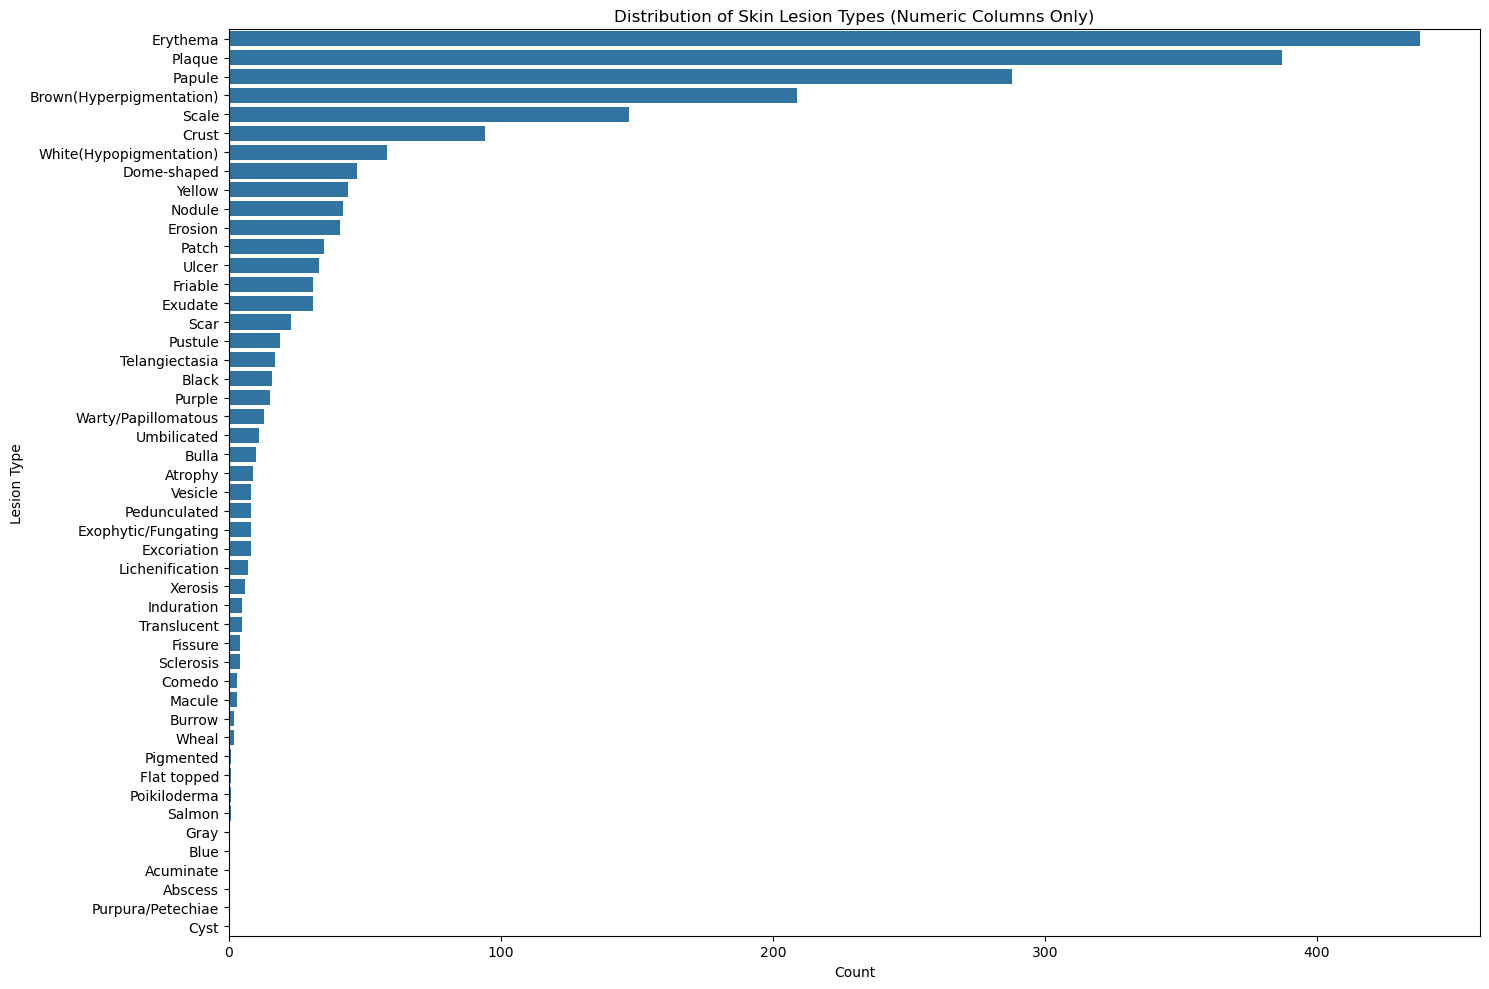

In [6]:
plot_lesion_distribution(test_df)

In [7]:
#skin conditions per image:
def analyze_lesions_per_image(df):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    lesions_per_image = df[numeric_columns].sum(axis=1)
    print(f"Average number of lesions per image: {lesions_per_image.mean():.2f}")
    print(f"Median number of lesions per image: {lesions_per_image.median():.2f}")
    print(f"Max number of lesions in an image: {lesions_per_image.max()}")
    print(f"Min number of lesions in an image: {lesions_per_image.min()}")

analyze_lesions_per_image(train_df)

Average number of lesions per image: 2.67
Median number of lesions per image: 3.00
Max number of lesions in an image: 9
Min number of lesions in an image: 0


In [8]:
#exploring common lesion combinations:
def analyze_lesion_combinations(df):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    lesion_combinations = df[numeric_columns].apply(lambda x: ','.join(x.index[x.astype(bool)]), axis=1)
    top_combinations = lesion_combinations.value_counts().head(10)
    print("Top 10 most common lesion combinations:")
    print(top_combinations)

analyze_lesion_combinations(train_df)

Top 10 most common lesion combinations:
                                         268
Plaque,Erythema                          227
Papule,Erythema                          152
Papule,Brown(Hyperpigmentation)          140
Plaque,Scale,Erythema                    128
Plaque,Brown(Hyperpigmentation)          114
Papule,Scale,Erythema                     49
Papule,Plaque,Erythema                    42
Plaque,Scale,Brown(Hyperpigmentation)     31
Patch,Brown(Hyperpigmentation)            30
Name: count, dtype: int64



Class Imbalance Analysis:
Erythema: 1322 (54.49%)
Plaque: 1203 (49.59%)
Papule: 872 (35.94%)
Brown(Hyperpigmentation): 624 (25.72%)
Scale: 414 (17.07%)
Crust: 324 (13.36%)
Yellow: 150 (6.18%)
White(Hypopigmentation): 145 (5.98%)
Nodule: 130 (5.36%)
Erosion: 115 (4.74%)
Dome-shaped: 111 (4.58%)
Ulcer: 90 (3.71%)
Friable: 85 (3.50%)
Patch: 80 (3.30%)
Exudate: 79 (3.26%)
Scar: 70 (2.89%)
Black: 69 (2.84%)
Telangiectasia: 60 (2.47%)
Pustule: 49 (2.02%)
Purple: 46 (1.90%)
Atrophy: 40 (1.65%)
Bulla: 39 (1.61%)
Warty/Papillomatous: 36 (1.48%)
Vesicle: 29 (1.20%)
Exophytic/Fungating: 28 (1.15%)
Excoriation: 24 (0.99%)
Macule: 24 (0.99%)
Fissure: 24 (0.99%)
Umbilicated: 23 (0.95%)
Xerosis: 21 (0.87%)
Comedo: 18 (0.74%)
Induration: 17 (0.70%)
Pedunculated: 15 (0.62%)
Sclerosis: 15 (0.62%)
Flat topped: 13 (0.54%)
Lichenification: 12 (0.49%)
Wheal: 12 (0.49%)
Translucent: 11 (0.45%)
Purpura/Petechiae: 9 (0.37%)
Salmon: 7 (0.29%)
Acuminate: 6 (0.25%)
Blue: 4 (0.16%)
Cyst: 4 (0.16%)
Abscess: 3 (0.1

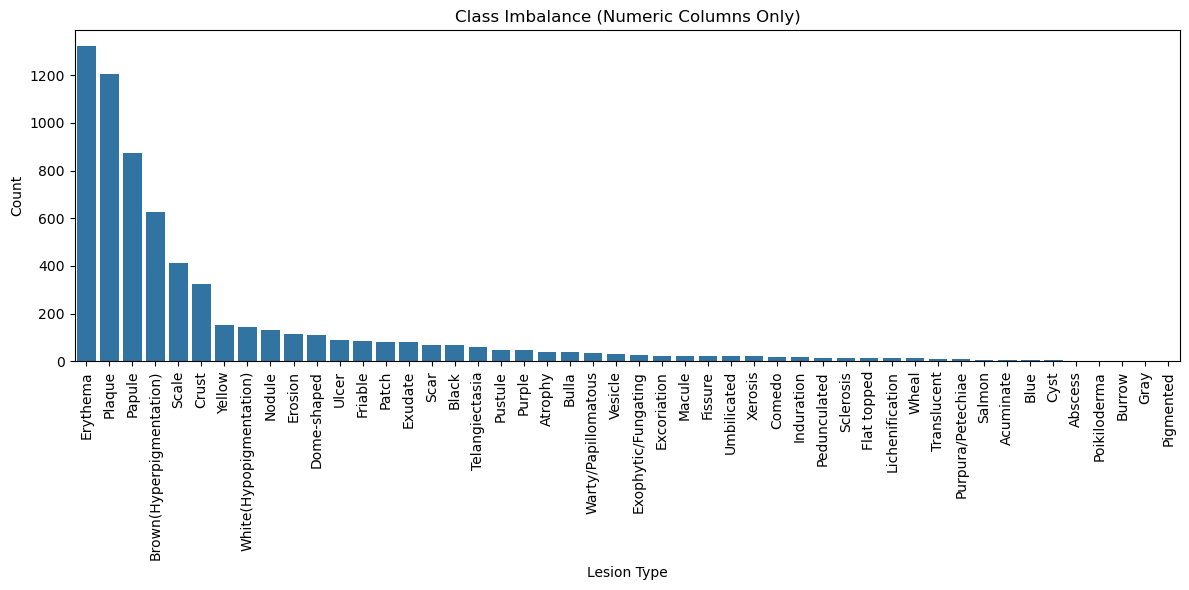

In [9]:
#analysing class imbalance:
def analyze_class_imbalance(df):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    class_balance = df[numeric_columns].sum().sort_values(ascending=False)
    total_samples = len(df)
    
    print("\nClass Imbalance Analysis:")
    for lesion, count in class_balance.items():
        percentage = (count / total_samples) * 100
        print(f"{lesion}: {count} ({percentage:.2f}%)")

    plt.figure(figsize=(12, 6))
    sns.barplot(x=class_balance.index, y=class_balance.values)
    plt.title('Class Imbalance (Numeric Columns Only)')
    plt.xlabel('Lesion Type')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

analyze_class_imbalance(train_df)

### Based on the above distribution/presence of skin conditions, we have decided to predict the following columns:

In [10]:
# List of columns to predict
columns_to_predict = ['Erythema', 'Plaque', 'Papule', 'Brown(Hyperpigmentation)', 'Scale', 'Crust', 'Yellow', 'White(Hypopigmentation)', 'Nodule', 'Erosion']

In [11]:
#Creating class for dataset generation:
class SkinLesionDataset(Dataset):
    def __init__(self, dataframe, img_dir, columns_to_keep, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.columns_to_keep = columns_to_keep
        self.transform = transform
        self.to_tensor = transforms.ToTensor()
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['skincap_file_path']
        img_path = os.path.join(self.img_dir, img_name)
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            else:
                image = self.to_tensor(image)
        except Exception as e:
            print(f"Error loading image: {img_path}")
            print(f"Error details: {str(e)}")
            image = torch.zeros((3, 224, 224))
        
        labels = torch.FloatTensor(self.dataframe.iloc[idx][self.columns_to_keep].values.astype(np.float32))
        return image, labels

In [12]:
# Data transformations:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Data transformations for validation and test sets:
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [13]:
# Model definition:
class SkinLesionModel(nn.Module):
    def __init__(self, num_classes):
        super(SkinLesionModel, self).__init__()
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        num_ftrs = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_ftrs, num_classes)
        )
    
    def forward(self, x):
        return self.efficientnet(x)

In [14]:
# Early stopping implementation:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')
        self.val_loss_min = val_loss

In [15]:
# Mixup augmentation function:
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [16]:
#setting up the device(GPU):
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


In [17]:
# Initialize model:
model = SkinLesionModel(num_classes=len(columns_to_predict)).to(device)
print(model)

#loss function, optimizer, and scheduler:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

SkinLesionModel(
  (efficientnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
             

/Users/architmurgudkar/pytorch-test/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/architmurgudkar/pytorch-test/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/architmurgudkar/pytorch-test/env/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [18]:
# Create datasets and data loaders:
train_dataset = SkinLesionDataset(train_df, img_dir, columns_to_predict, transform=train_transforms)
val_dataset = SkinLesionDataset(val_df, img_dir, columns_to_predict, transform=val_test_transforms)
test_dataset = SkinLesionDataset(test_df, img_dir, columns_to_predict, transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## Training:

In [19]:
# Function to compute metrics during training/validation/testing:
def compute_metrics(outputs, labels):
    preds = torch.sigmoid(outputs) > 0.3  # Apply sigmoid and threshold
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    
    accuracy = accuracy_score(labels.flatten(), preds.flatten())
    f1 = f1_score(labels, preds, average='micro', zero_division=1)
    precision = precision_score(labels, preds, average='micro', zero_division=1)
    recall = recall_score(labels, preds, average='micro', zero_division=1)
    
    return accuracy, f1, precision, recall


In [20]:
# Training function:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for images, labels in tqdm(train_loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)
        
        # Mixup augmentation
        images, targets_a, targets_b, lam = mixup_data(images, labels, alpha=0.2)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item()
        
        # Store outputs and labels for metric calculation
        all_preds.append(outputs)
        all_labels.append(labels)
    
    # Convert lists to tensors for metric calculation
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    
    accuracy, f1, precision, recall = compute_metrics(all_preds, all_labels)
    
    return running_loss / len(train_loader), accuracy, f1, precision, recall


In [21]:
# Modify the evaluate_model function
def evaluate_model(model, loader, criterion, device, phase='Validation'):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc=phase):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            all_preds.append(outputs)
            all_labels.append(labels)
    
    # Convert lists to tensors for metric calculation
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    
    loss = running_loss / len(loader)
    accuracy, f1, precision, recall = compute_metrics(all_preds, all_labels)
    
    if phase == 'Testing':
        # Return all 6 values during the test phase (including all_labels and all_preds)
        return loss, f1, precision, recall, accuracy, all_labels.cpu().numpy(), all_preds.cpu().numpy()
    else:
        # Return only 5 values during training/validation phase
        return loss, f1, precision, recall, accuracy


In [22]:
# Training loop with early stopping, scheduler, and training metrics
num_epochs = 30
best_f1 = 0.0
early_stopping = EarlyStopping(patience=5, verbose=True)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Training phase
    train_loss, train_accuracy, train_f1, train_precision, train_recall = train_model(model, train_loader, criterion, optimizer, device)
    
    # Validation phase (only expecting 5 values)
    val_loss, val_f1, val_precision, val_recall, val_accuracy = evaluate_model(model, val_loader, criterion, device, phase='Validation')
    
    # Print metrics for training and validation
    print(f"Train Loss: {train_loss:.4f} \nTrain Accuracy: {train_accuracy:.4f}, Train F1: {train_f1:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f} \n")
    print(f"Val Loss: {val_loss:.4f} \nVal Accuracy: {val_accuracy:.4f}, Val F1: {val_f1:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f} \n")
    
    # Adjust learning rate based on validation performance
    scheduler.step(val_f1)
    
    # Save best model based on validation F1 score
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), 'best_model.pth')
        print("Saved best model")
    
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch 1/30


Validation: 100%|███████████████████████████████| 50/50 [00:05<00:00,  9.89it/s]


Train Loss: 0.4263 
Train Accuracy: 0.7366, Train F1: 0.5099, Train Precision: 0.4296, Train Recall: 0.6271 

Val Loss: 0.3865 
Val Accuracy: 0.8115, Val F1: 0.5978, Val Precision: 0.5539, Val Recall: 0.6494 

Saved best model
Epoch 2/30


Validation: 100%|███████████████████████████████| 50/50 [00:04<00:00, 11.03it/s]


Train Loss: 0.3875 
Train Accuracy: 0.7757, Train F1: 0.5433, Train Precision: 0.4893, Train Recall: 0.6109 

Val Loss: 0.3460 
Val Accuracy: 0.8355, Val F1: 0.6403, Val Precision: 0.6063, Val Recall: 0.6783 

Saved best model
Epoch 3/30


Validation: 100%|███████████████████████████████| 50/50 [00:04<00:00, 10.86it/s]


Train Loss: 0.3709 
Train Accuracy: 0.7790, Train F1: 0.5467, Train Precision: 0.4953, Train Recall: 0.6101 

Val Loss: 0.3495 
Val Accuracy: 0.8385, Val F1: 0.6420, Val Precision: 0.6153, Val Recall: 0.6712 

Saved best model
Epoch 4/30


Validation: 100%|███████████████████████████████| 50/50 [00:04<00:00, 10.65it/s]


Train Loss: 0.3609 
Train Accuracy: 0.7809, Train F1: 0.5505, Train Precision: 0.4987, Train Recall: 0.6143 

Val Loss: 0.3345 
Val Accuracy: 0.8420, Val F1: 0.6517, Val Precision: 0.6217, Val Recall: 0.6848 

Saved best model
Epoch 5/30


Validation: 100%|███████████████████████████████| 50/50 [00:04<00:00, 10.03it/s]


Train Loss: 0.3581 
Train Accuracy: 0.7875, Train F1: 0.5640, Train Precision: 0.5110, Train Recall: 0.6292 

Val Loss: 0.3331 
Val Accuracy: 0.8465, Val F1: 0.6626, Val Precision: 0.6303, Val Recall: 0.6983 

Saved best model
Epoch 6/30


Validation: 100%|███████████████████████████████| 50/50 [00:04<00:00, 10.03it/s]


Train Loss: 0.3438 
Train Accuracy: 0.7863, Train F1: 0.5575, Train Precision: 0.5089, Train Recall: 0.6163 

Val Loss: 0.3381 
Val Accuracy: 0.8287, Val F1: 0.6585, Val Precision: 0.5777, Val Recall: 0.7656 

Epoch 7/30


Validation: 100%|███████████████████████████████| 50/50 [00:04<00:00, 10.06it/s]


Train Loss: 0.3438 
Train Accuracy: 0.7845, Train F1: 0.5549, Train Precision: 0.5054, Train Recall: 0.6150 

Val Loss: 0.3317 
Val Accuracy: 0.8301, Val F1: 0.6551, Val Precision: 0.5828, Val Recall: 0.7479 

Epoch 8/30


Validation: 100%|███████████████████████████████| 50/50 [00:04<00:00, 10.05it/s]


Train Loss: 0.3389 
Train Accuracy: 0.7840, Train F1: 0.5546, Train Precision: 0.5045, Train Recall: 0.6158 

Val Loss: 0.3339 
Val Accuracy: 0.8362, Val F1: 0.6603, Val Precision: 0.5975, Val Recall: 0.7379 

Epoch 9/30


Validation: 100%|███████████████████████████████| 50/50 [00:04<00:00, 10.07it/s]


Train Loss: 0.3289 
Train Accuracy: 0.7826, Train F1: 0.5515, Train Precision: 0.5019, Train Recall: 0.6120 

Val Loss: 0.3199 
Val Accuracy: 0.8429, Val F1: 0.6720, Val Precision: 0.6116, Val Recall: 0.7456 

Saved best model
Epoch 10/30


Validation: 100%|███████████████████████████████| 50/50 [00:04<00:00, 10.21it/s]


Train Loss: 0.3176 
Train Accuracy: 0.7997, Train F1: 0.5856, Train Precision: 0.5342, Train Recall: 0.6479 

Val Loss: 0.3229 
Val Accuracy: 0.8450, Val F1: 0.6764, Val Precision: 0.6154, Val Recall: 0.7509 

Saved best model
Epoch 11/30


Validation: 100%|███████████████████████████████| 50/50 [00:05<00:00, 10.00it/s]


Train Loss: 0.3205 
Train Accuracy: 0.7852, Train F1: 0.5585, Train Precision: 0.5068, Train Recall: 0.6220 

Val Loss: 0.3253 
Val Accuracy: 0.8312, Val F1: 0.6616, Val Precision: 0.5831, Val Recall: 0.7645 

Epoch 12/30


Validation: 100%|███████████████████████████████| 50/50 [00:05<00:00,  9.95it/s]


Train Loss: 0.3101 
Train Accuracy: 0.7918, Train F1: 0.5693, Train Precision: 0.5194, Train Recall: 0.6299 

Val Loss: 0.3231 
Val Accuracy: 0.8460, Val F1: 0.6779, Val Precision: 0.6178, Val Recall: 0.7509 

Saved best model
Epoch 13/30


Validation: 100%|███████████████████████████████| 50/50 [00:05<00:00,  9.96it/s]


Train Loss: 0.3011 
Train Accuracy: 0.7964, Train F1: 0.5748, Train Precision: 0.5285, Train Recall: 0.6301 

Val Loss: 0.3301 
Val Accuracy: 0.8462, Val F1: 0.6689, Val Precision: 0.6248, Val Recall: 0.7196 

Epoch 14/30


Validation: 100%|███████████████████████████████| 50/50 [00:05<00:00,  9.96it/s]

Train Loss: 0.2974 
Train Accuracy: 0.8035, Train F1: 0.5923, Train Precision: 0.5416, Train Recall: 0.6533 

Val Loss: 0.3419 
Val Accuracy: 0.8390, Val F1: 0.6512, Val Precision: 0.6114, Val Recall: 0.6966 

Early stopping


In [28]:
# Test set evaluation (expecting 6 values here)
print("Evaluating on test set...")

model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_f1, test_precision, test_recall, test_accuracy, test_labels, test_preds = evaluate_model(model, test_loader, criterion, device, phase='Testing')
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1: {test_f1:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}")

Evaluating on test set...


/var/folders/nv/j4_t175j49n9hdxl0mfy3jbh0000gn/T/ipykernel_10200/1799877723.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.

Test Loss: 0.3447, Test Accuracy: 0.8345, Test F1: 0.6636, Test Precision: 0.6062, Test Recall: 0.7328


In [29]:
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np

# Apply sigmoid to convert logits to probabilities
test_preds_prob = torch.sigmoid(torch.tensor(test_preds)).numpy()

# Assuming test_labels and test_preds_prob are numpy arrays:
precisions, recalls, thresholds = precision_recall_curve(test_labels.ravel(), test_preds_prob.ravel())

# Calculate F1-scores for all thresholds
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

# Find the threshold with the highest F1-score
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]

print(f"Best Threshold: {best_threshold}")


Best Threshold: 0.3964751958847046


In [25]:
# Apply the best threshold to get binary predictions:
test_preds_binary = (test_preds_prob > best_threshold).astype(int)

# Generate and print the classification report:
class_names = columns_to_predict  # Assuming this contains your class labels
print("\nFinal Classification Report:")
print(classification_report(test_labels, test_preds_binary, target_names=class_names, zero_division=1))


Final Classification Report:
                          precision    recall  f1-score   support

                Erythema       0.73      0.92      0.81       438
                  Plaque       0.71      0.84      0.77       387
                  Papule       0.69      0.69      0.69       288
Brown(Hyperpigmentation)       0.67      0.59      0.63       209
                   Scale       0.53      0.37      0.44       147
                   Crust       0.42      0.35      0.38        94
                  Yellow       0.64      0.36      0.46        44
 White(Hypopigmentation)       0.48      0.24      0.32        58
                  Nodule       0.37      0.17      0.23        42
                 Erosion       0.23      0.17      0.19        41

               micro avg       0.67      0.68      0.67      1748
               macro avg       0.55      0.47      0.49      1748
            weighted avg       0.65      0.68      0.65      1748
             samples avg       0.69      0.7

In [30]:
# After training is done, save the final model
torch.save(model.state_dict(), 'multilabel_model_on_top10.pth')
print("Saved final model after training.")

Saved final model after training.
